In [2]:
import numba
import sys
sys.path.insert(0, '../../../python_lib')
import networkx as nx
import numpy as np
import graph_gen
import model
import random
from collections import defaultdict
import torch
import math
import solvers

In [3]:
%matplotlib inline

In [11]:
J = []
with open("lattice3d.txt") as f:
    for row_s in f.readlines():
        row  = [float(x) for x in row_s.split()]
        J.append(row)

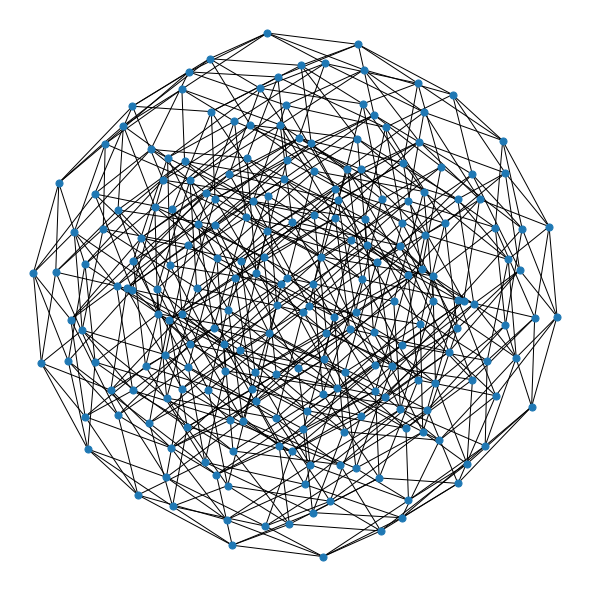

In [12]:
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout

J = np.array(J)
G=nx.from_numpy_matrix(J)
pos = graphviz_layout(G, args='')
plt.figure(figsize=(8, 8))
nx.draw(G, pos, node_size=50)
plt.axis('equal')
plt.show()

In [13]:
J_interaction = (J!=0).astype(int)

In [14]:
J.shape

(216, 216)

In [15]:
import imp 
N = J.shape[0]
H = np.zeros(N)
#J_interaction = graph_gen.reorder_graph(J_interaction, 
#                                        root = 0)
#H = np.random.random(N)
betas_fast = [0.20, 0.21]

In [16]:
tree = model.model(N, H, J, J_interaction)

In [17]:
import solvers
imp.reload(solvers)

res_nn = solvers.nn_sol(tree, betas_fast, 
                        max_step=1000, bias = True, 
                        z2 = False, x_hat_clip = False
                       )
res_nn["name"]="nn"

fe: -3.791 std_fe: 3.17E-02 M: 0.010 S: 0.623 E: -0.676: 0.0243, B1 = 0.043
fe: -3.646 std_fe: 2.94E-02 M: 0.304 S: 0.578 E: -0.894: 0.313, B1 = 0.6090


In [18]:
res_nn_z2 = solvers.nn_sol(tree, betas_fast, max_step=1000,
                           bias = True, z2 = True, x_hat_clip = False)
res_nn_z2["name"]="nn_z2"

fe: -3.802 std_fe: 2.66E-02 M: 0.008 S: 0.604 E: -0.780: 0.0268, B1 = 0.454
fe: -3.660 std_fe: 2.67E-02 M: 0.008 S: 0.570 E: -0.944: 0.0255, B1 = 0.700


In [80]:
res_nn_is = solvers.nn_sol(tree, [0.2,0.21], max_step=2000,
                           bias = True, z2 = False, x_hat_clip = False, 
                           i_sampling=True, stats=30000, lr=0.01, )
res_nn_is["name"]="nn_is"

fe: -3.817 std_fe: 6.12E-04 M: 0.018 S: 0.599 E: -0.821: 0.024, B1 = -0.0121
fe: -3.673 std_fe: 1.76E-03 M: 0.161 S: 0.582 E: -0.899: 0.319, B1 = 0.653


In [23]:
import bp_solver
imp.reload(bp_solver)
import solvers
imp.reload(solvers)
res_bp = solvers.bp_sol(tree, betas_fast, val_rand=0.6, 
                        error=1e-10)
res_bp["name"]="bp"

fe: -3.781, ener: -0.625, M: 0.000, iter 1000
fe: -3.638, ener: -0.975, M: 0.398, iter 192


# Analysis results

In [81]:
corr_mc = []
corr_dc = []

with open('corrs3d.txt') as f:
    for row_s in f.readlines():
        row  = [float(x) for x in row_s.split()]
        corr_mc.append(row[0])
        corr_dc.append(row[1])


In [82]:
def flatten_C(res):
    flatten = []
    for beta, v in enumerate(res["C_ij"]):
        c_ij = res["C_ij"][beta]
        c_ij = np.triu(c_ij)
        c_ij = c_ij.flatten("C")
        c_ij = c_ij[c_ij!=0]
        flatten.append(c_ij)
    return flatten

In [83]:
c_ij_nn = flatten_C(res_nn)
c_ij_z2 = flatten_C(res_nn_z2)
c_ij_is = flatten_C(res_nn_is)
c_ij_bp = flatten_C(res_bp)

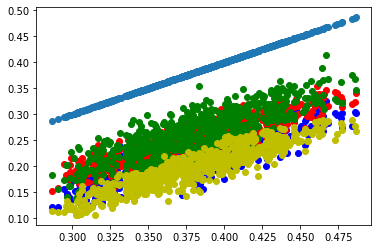

In [84]:
import matplotlib.pyplot as plt
plt.plot(corr_mc, c_ij_nn[0], "bo")
plt.plot(corr_mc, c_ij_z2[0], "ro")
plt.plot(corr_mc, c_ij_is[0], "go")
#plt.plot(corr_mc, corr_dc, "yo")
plt.plot(corr_mc, c_ij_bp[0], "yo")
plt.plot(corr_mc, corr_mc, "o")

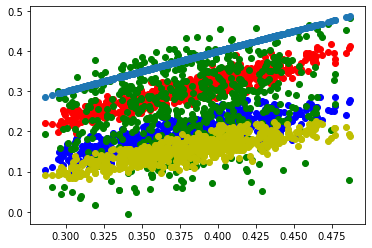

In [85]:
import matplotlib.pyplot as plt
plt.plot(corr_mc, c_ij_nn[1], "bo")
plt.plot(corr_mc, c_ij_z2[1], "ro")
plt.plot(corr_mc, c_ij_is[1], "go")
#plt.plot(corr_mc, corr_dc, "yo")
plt.plot(corr_mc, c_ij_bp[1], "yo")
plt.plot(corr_mc, corr_mc, "o")

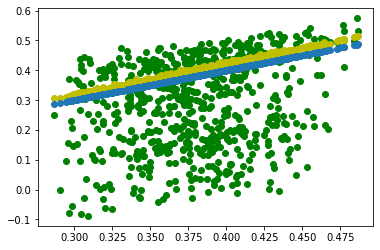

In [75]:
import matplotlib.pyplot as plt
#plt.plot(corr_mc, c_ij_nn[0], "bo")
#plt.plot(corr_mc, c_ij_z2[0], "ro")
plt.plot(corr_mc, c_ij_is[1], "go")
plt.plot(corr_mc, corr_dc, "yo")
#plt.plot(corr_mc, c_ij_bp[0], "yo")
plt.plot(corr_mc, corr_mc, "o")

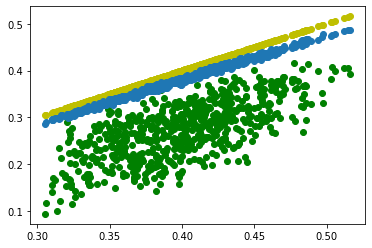

In [55]:
import matplotlib.pyplot as plt
#plt.plot(corr_mc, c_ij_nn[0], "bo")
#plt.plot(corr_mc, c_ij_z2[0], "ro")
plt.plot(corr_dc, c_ij_is[1], "go")
plt.plot(corr_dc, corr_dc, "yo")
#plt.plot(corr_mc, c_ij_bp[0], "yo")
plt.plot(corr_dc, corr_mc, "o")

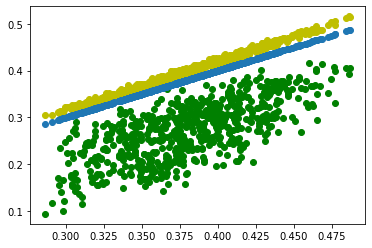

In [50]:
import matplotlib.pyplot as plt
#plt.plot(corr_mc, c_ij_nn[0], "bo")
#plt.plot(corr_mc, c_ij_z2[0], "ro")
plt.plot(corr_mc, c_ij_is[1], "go")
plt.plot(corr_mc, corr_dc, "yo")
#plt.plot(corr_mc, c_ij_bp[0], "yo")
plt.plot(corr_mc, corr_mc, "o")

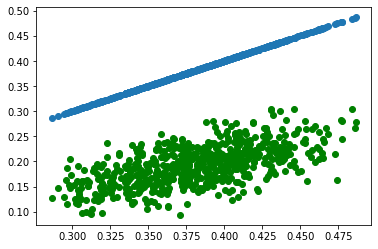

In [49]:
import matplotlib.pyplot as plt
#plt.plot(corr_mc, c_ij_nn[0], "bo")
#plt.plot(corr_mc, c_ij_z2[0], "ro")
plt.plot(corr_mc, c_ij_is[2], "go")
#plt.plot(corr_mc, corr_dc, "yo")
#plt.plot(corr_mc, c_ij_bp[0], "yo")
plt.plot(corr_mc, corr_mc, "o")

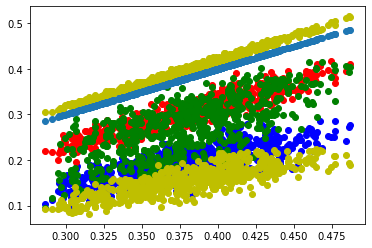

In [48]:
import matplotlib.pyplot as plt
plt.plot(corr_mc, c_ij_nn[1], "bo")
plt.plot(corr_mc, c_ij_z2[1], "ro")
plt.plot(corr_mc, c_ij_is[1], "go")
plt.plot(corr_mc, corr_dc, "yo")
plt.plot(corr_mc, c_ij_bp[1], "yo")
plt.plot(corr_mc, corr_mc, "o")

In [45]:
%matplotlib inline
import imp
imp.reload(solvers)
label="fe"
plt= solvers.plot_quantity(label, res_ex, [res_bp, res_nn], init_=0)
#plt.ylim(-0.001,0.11)
plt.show()

NameError: name 'res_ex' is not defined

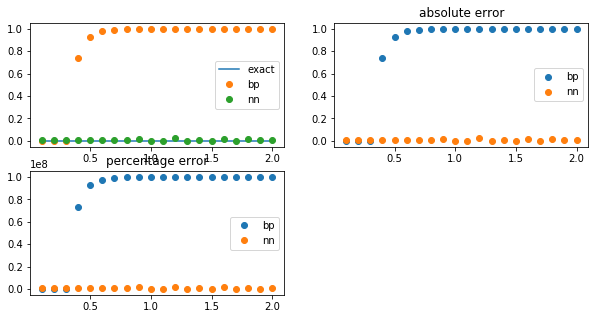

In [12]:
%matplotlib inline
label="M"
plt= solvers.plot_quantity(label, res_ex, [res_bp, res_nn])
plt.show()

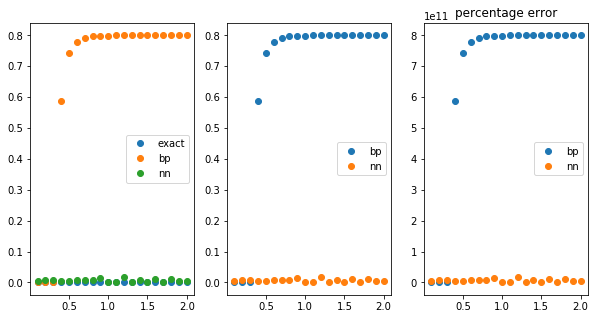

In [13]:
%matplotlib inline
label="M_i"
plt= solvers.plot_quantity_sum(label, res_ex, [res_bp, res_nn], init_=0)
plt.show()

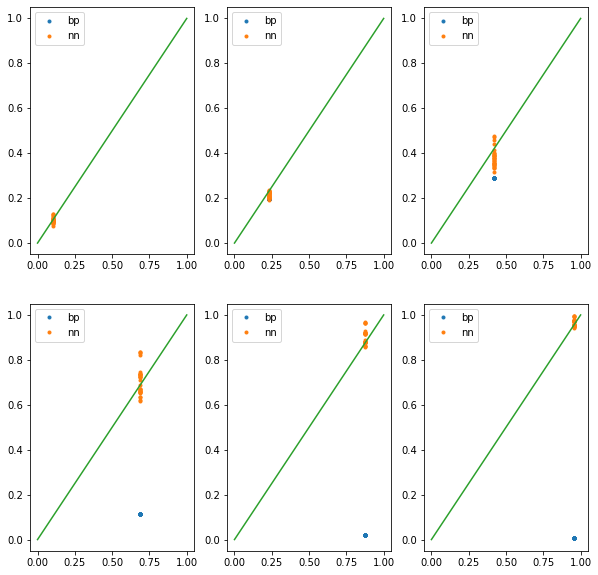

In [14]:
import solvers
imp.reload(solvers)
plt = solvers.plot_all_corr(betas_fast[0:6], res_ex, [res_bp, res_nn], J_interaction)
plt.show()